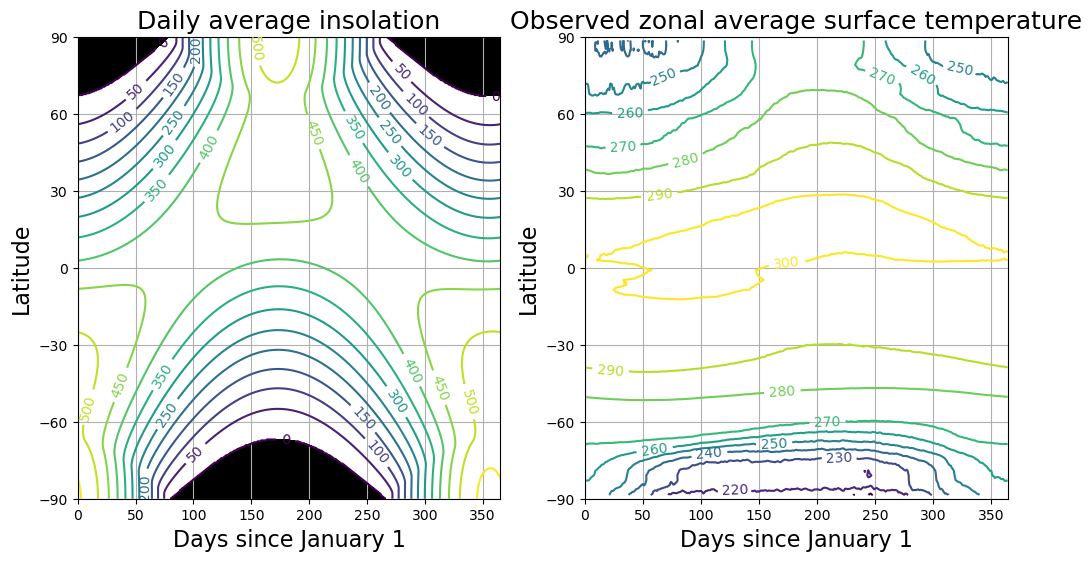

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import climlab
from climlab import constants as const

#  Calculate daily average insolation as function of latitude and time of year
lat = np.linspace( -90., 90., 500 )
days = np.linspace(0, const.days_per_year, 365 )
Q = climlab.solar.insolation.daily_insolation( lat, days )

##  daily surface temperature from  NCEP reanalysis
#ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_url = "/Users/yuchiaol_ntuas/Desktop/ebooks/data/"
ncep_temp = xr.open_dataset( ncep_url + "skt.sfc.day.1981-2010.ltm.nc", decode_times=False)
#url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/NCEP/NCEP/clima/'
#skt_path = 'surface_gauss/skt'
#ncep_temp = xr.open_dataset(url+skt_path)
ncep_temp_zon = ncep_temp.skt.mean(dim='lon')

fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
CS = ax1.contour( days, lat, Q , levels = np.arange(0., 600., 50.) )
ax1.clabel(CS, CS.levels, inline=True, fmt='%1.0f', fontsize=10)
ax1.set_title('Daily average insolation', fontsize=18 )
ax1.contourf ( days, lat, Q, levels=[-100., 0.], colors='k' )

ax2 = fig.add_subplot(122)
CS = ax2.contour( (ncep_temp.time - ncep_temp.time[0])/const.hours_per_day, ncep_temp.lat, 
                 ncep_temp_zon.T, levels=np.arange(210., 310., 10. ) )
ax2.clabel(CS, CS.levels, inline=True, fmt='%1.0f', fontsize=10)
ax2.set_title('Observed zonal average surface temperature', fontsize=18 )

for ax in [ax1,ax2]:
    ax.set_xlabel('Days since January 1', fontsize=16 )
    ax.set_ylabel('Latitude', fontsize=16 )
    ax.set_yticks([-90,-60,-30,0,30,60,90])
    ax.grid()

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (40, 1) 
  Tatm: (40, 30) 
The subprocess tree: 
RCM: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Insolation: <class 'climlab.radiation.insolation.DailyInsolation'>
   Fixed Relative Humidity: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   Convective Adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>

Integrating for 81 steps, 81.0 days, or 0.22177064972229385 years.


Total elapsed time is 0.22177064972229385 years.
Integrating for 91 steps, 91.99999999999999 days, or 0.2518876515364325 years.


Total elapsed time is 0.4709203920028956 years.
Integrating for 94 steps, 94.00000000000001 days, or 0.2573634700480941 years.


Total elapsed time is 0.7282838620509897 years.
Integrating for 91 steps, 91.0 days, or 0.24914974228060174 years.


Total elapsed time is 0.9774336043315914 years.


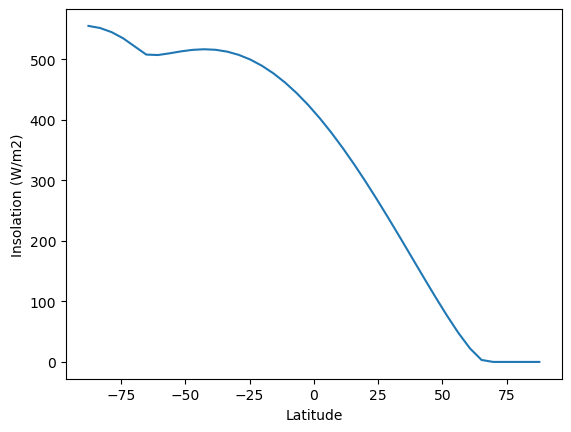

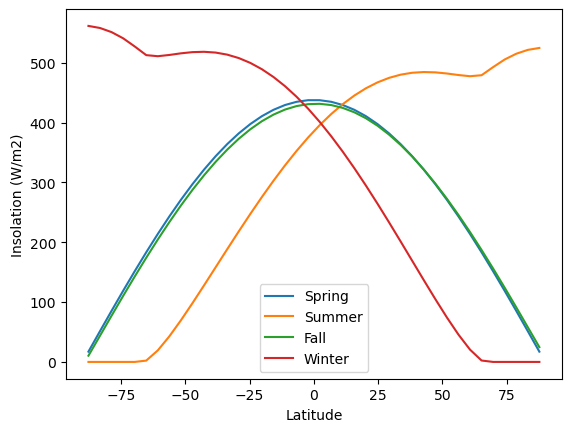

In [2]:
# A two-dimensional domain
state = climlab.column_state(num_lev=30, num_lat=40, water_depth=10.)
#  Specified relative humidity distribution
h2o = climlab.radiation.ManabeWaterVapor(name='Fixed Relative Humidity', state=state)
#  Hard convective adjustment
conv = climlab.convection.ConvectiveAdjustment(name='Convective Adjustment', state=state, adj_lapse_rate=6.5)
#  Daily insolation as a function of latitude and time of year
sun = climlab.radiation.DailyInsolation(name='Insolation', domains=state['Ts'].domain)
#  Couple the radiation to insolation and water vapor processes
rad = climlab.radiation.RRTMG(name='Radiation',
                             state=state, 
                             specific_humidity=h2o.q, 
                             albedo=0.125,
                             coszen=sun.coszen,
                             irradiance_factor=sun.insolation)
model = climlab.couple([rad,sun,h2o,conv], name='RCM')
print( model)

model.compute_diagnostics()

fig, ax = plt.subplots()
ax.plot(model.lat, model.insolation)
ax.set_xlabel('Latitude')
ax.set_ylabel('Insolation (W/m2)');

#climlab.radiation.DailyInsolation
#climlab.radiation.AnnualMeanInsolation

#  model is initialized on Jan. 1

#  integrate forward just under 1/4 year... should get about to the NH spring equinox
model.integrate_days(31+28+22)
Q_spring = model.insolation.copy()
#  Then forward to NH summer solstice
model.integrate_days(31+30+31)
Q_summer = model.insolation.copy()
#  and on to autumnal equinox
model.integrate_days(30+31+33)
Q_fall = model.insolation.copy()
#  and finally to NH winter solstice
model.integrate_days(30+31+30)
Q_winter = model.insolation.copy()

fig, ax = plt.subplots()
ax.plot(model.lat, Q_spring, label='Spring')
ax.plot(model.lat, Q_summer, label='Summer')
ax.plot(model.lat, Q_fall, label='Fall')
ax.plot(model.lat, Q_winter, label='Winter')
ax.legend()
ax.set_xlabel('Latitude')
ax.set_ylabel('Insolation (W/m2)');


Integrating for 1460 steps, 1460.9688 days, or 4.0 years.


Total elapsed time is 4.974781117844542 years.


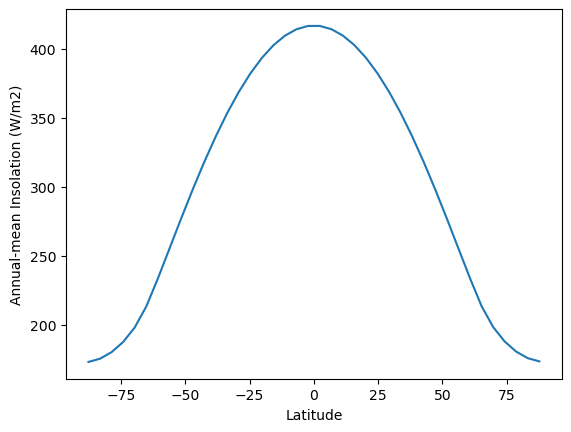

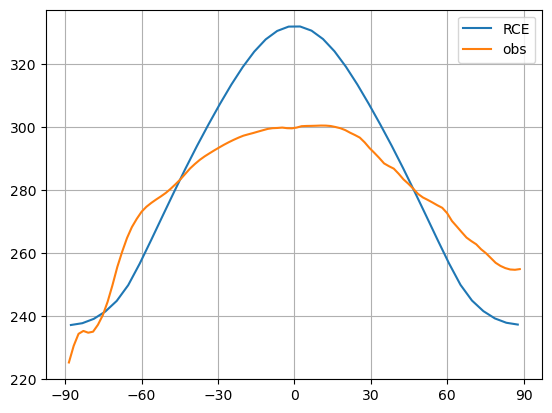

In [3]:
# time integration

model.integrate_years(4.)
#model.integrate_years(1.)

model.timeave.keys()

fig, ax = plt.subplots()
ax.plot(model.lat, model.timeave['insolation'])
ax.set_xlabel('Latitude')
ax.set_ylabel('Annual-mean Insolation (W/m2)')

# Plot annual mean surface temperature in the model,
#   compare to observed annual mean surface temperatures
fig, ax = plt.subplots()
ax.plot(model.lat, model.timeave['Ts'], label='RCE')
ax.plot(ncep_temp_zon.lat, ncep_temp_zon.mean(dim='time'), label='obs')
ax.set_xticks(range(-90,100,30))
ax.grid(); ax.legend();


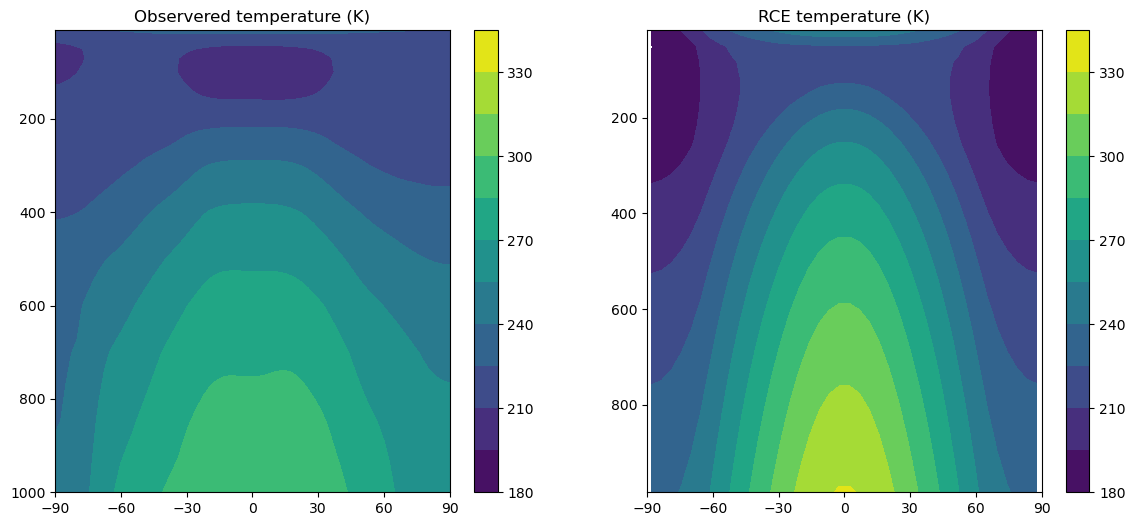

In [4]:
#  Observed air temperature from NCEP reanalysis
## The NOAA ESRL server is shutdown! January 2019
## may shutdown again in 2025
ncep_url = "/Users/yuchiaol_ntuas/Desktop/ebooks/data/"
ncep_air = xr.open_dataset( ncep_url + "air.mon.1981-2010.ltm.nc", decode_times=False)
#air = xr.open_dataset(url+'pressure/air')
#ncep_air = air.rename({'lev':'level'})
level_ncep_air = ncep_air.level
lat_ncep_air = ncep_air.lat
Tzon = ncep_air.air.mean(dim=('time','lon'))

#  Compare temperature profiles in RCE and observations
contours = np.arange(180., 350., 15.)

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(1,2,1)
cax1 = ax1.contourf(lat_ncep_air, level_ncep_air, Tzon+const.tempCtoK, levels=contours)
fig.colorbar(cax1)
ax1.set_title('Observered temperature (K)')

ax2 = fig.add_subplot(1,2,2)
field = model.timeave['Tatm'].transpose()
cax2 = ax2.contourf(model.lat, model.lev, field, levels=contours)
fig.colorbar(cax2)
ax2.set_title('RCE temperature (K)')

for ax in [ax1, ax2]:
    ax.invert_yaxis()
    ax.set_xlim(-90,90)
    ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])


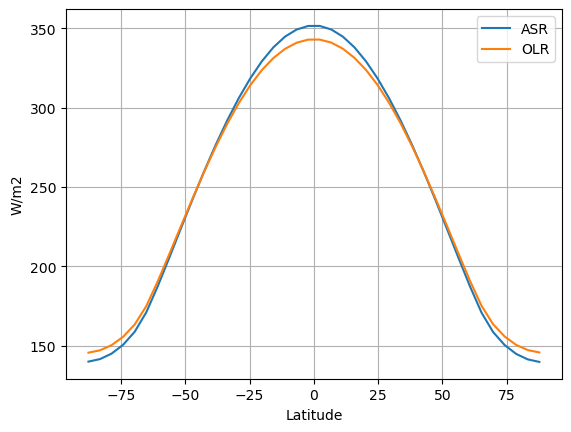

In [5]:
fig, ax = plt.subplots()
ax.plot(model.lat, model.timeave['ASR'], label='ASR')
ax.plot(model.lat, model.timeave['OLR'], label='OLR')
ax.set_xlabel('Latitude')
ax.set_ylabel('W/m2')
ax.legend(); ax.grid()

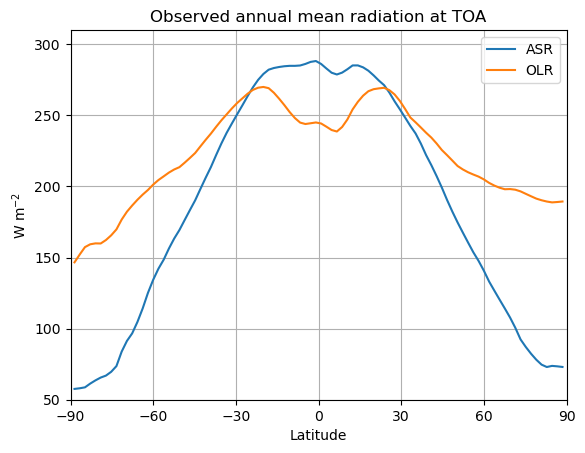

In [6]:
# Get TOA radiative flux data from NCEP reanalysis
# downwelling SW
ncep_url = "/Users/yuchiaol_ntuas/Desktop/ebooks/data/"
dswrf = xr.open_dataset(ncep_url + 'dswrf.ntat.mon.1981-2010.ltm.nc', decode_times=False)
#dswrf = xr.open_dataset(url + 'other_gauss/dswrf')
#  upwelling SW
uswrf = xr.open_dataset(ncep_url + 'uswrf.ntat.mon.1981-2010.ltm.nc', decode_times=False)
#uswrf = xr.open_dataset(url + 'other_gauss/uswrf')
#  upwelling LW
ulwrf = xr.open_dataset(ncep_url + 'ulwrf.ntat.mon.1981-2010.ltm.nc', decode_times=False)
#ulwrf = xr.open_dataset(url + 'other_gauss/ulwrf')

ASR = dswrf.dswrf - uswrf.uswrf
OLR = ulwrf.ulwrf

ASRzon = ASR.mean(dim=('time','lon'))
OLRzon = OLR.mean(dim=('time','lon'))

ticks = [-90, -60, -30, 0, 30, 60, 90]
fig, ax = plt.subplots()
ax.plot(ASRzon.lat, ASRzon, label='ASR')
ax.plot(OLRzon.lat, OLRzon, label='OLR')
ax.set_ylabel('W m$^{-2}$')
ax.set_xlabel('Latitude')
ax.set_xlim(-90,90); ax.set_ylim(50,310)
ax.set_xticks(ticks);
ax.set_title('Observed annual mean radiation at TOA')
ax.legend(); ax.grid();


Attempting to open the dataset  /Users/yuchiaol_ntuas/Desktop/ebooks/data/cpl_1850_f19.cam.h0.nc
Attempting to open the dataset  /Users/yuchiaol_ntuas/Desktop/ebooks/data/cpl_CO2ramp_f19.cam.h0.nc
Attempting to open the dataset  /Users/yuchiaol_ntuas/Desktop/ebooks/data/som_1850_f19.cam.h0.nc
Attempting to open the dataset  /Users/yuchiaol_ntuas/Desktop/ebooks/data/som_1850_2xCO2.cam.h0.nc


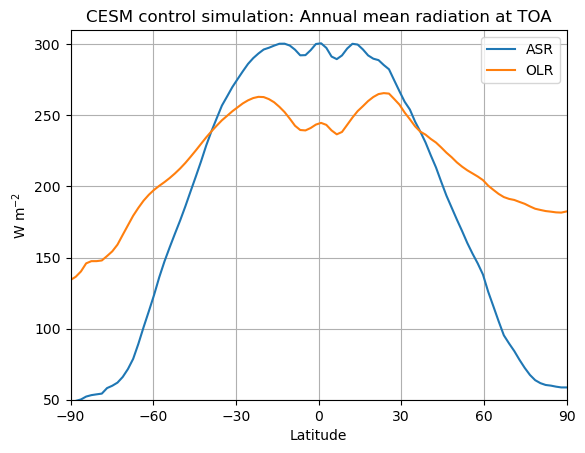

In [7]:
casenames = {'cpl_control': 'cpl_1850_f19',
             'cpl_CO2ramp': 'cpl_CO2ramp_f19',
             'som_control': 'som_1850_f19',
             'som_2xCO2':   'som_1850_2xCO2',
            }
# The path to the THREDDS server, should work from anywhere
#basepath = 'http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/'
#basepath = "/Users/yuchiaol_ntuas/Desktop/ebooks/data/"
# For better performance if you can access the roselab_rit filesystem (e.g. from JupyterHub)
#basepath = '/roselab_rit/cesm_archive/'
casepaths = {}
for name in casenames:
#    casepaths[name] = basepath + casenames[name] + '/concatenated/'
    casepaths[name] = "/Users/yuchiaol_ntuas/Desktop/ebooks/data/"

# make a dictionary of all the CAM atmosphere output
atm = {}
for name in casenames:
    path = casepaths[name] + casenames[name] + '.cam.h0.nc'
    print('Attempting to open the dataset ', path)
    atm[name] = xr.open_dataset(path)

lat_cesm = atm['cpl_control'].lat
ASR_cesm = atm['cpl_control'].FSNT
OLR_cesm = atm['cpl_control'].FLNT

# extract the last 10 years from the slab ocean control simulation
# and the last 20 years from the coupled control
nyears_slab = 10
nyears_cpl = 20
clim_slice_slab = slice(-(nyears_slab*12),None)
clim_slice_cpl = slice(-(nyears_cpl*12),None)

#  For now we're just working with the coupled control simulation
#  Take the time and zonal average
ASR_cesm_zon = ASR_cesm.isel(time=clim_slice_slab).mean(dim=('lon','time'))
OLR_cesm_zon = OLR_cesm.isel(time=clim_slice_slab).mean(dim=('lon','time'))

fig, ax = plt.subplots()
ax.plot(lat_cesm, ASR_cesm_zon, label='ASR')
ax.plot(lat_cesm, OLR_cesm_zon, label='OLR')
ax.set_ylabel('W m$^{-2}$')
ax.set_xlabel('Latitude')
ax.set_xlim(-90,90); ax.set_ylim(50,310)
ax.set_xticks([-90, -60, -30, 0, 30, 60, 90]);
ax.set_title('CESM control simulation: Annual mean radiation at TOA')
ax.legend(); ax.grid();


Text(0.5, 1.0, 'Total northward heat transport inferred from CESM control simulation')

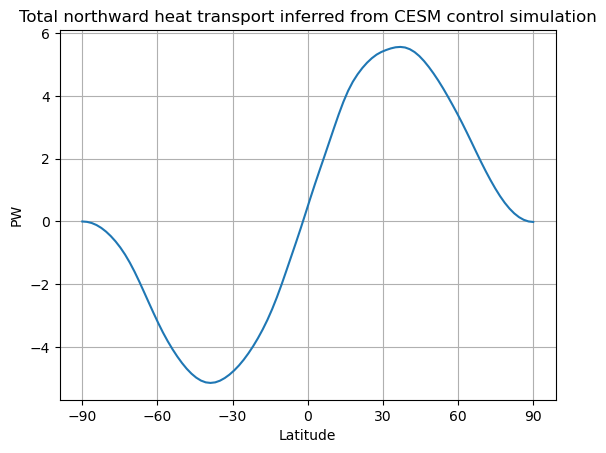

In [8]:
def inferred_heat_transport(energy_in, lat=None, latax=None):
    '''Compute heat transport as integral of local energy imbalance.
    Required input:
        energy_in: energy imbalance in W/m2, positive in to domain
    As either numpy array or xarray.DataArray
    If using plain numpy, need to supply these arguments:
        lat: latitude in degrees
        latax: axis number corresponding to latitude in the data
            (axis over which to integrate)
    returns the heat transport in PW.
    Will attempt to return data in xarray.DataArray if possible.
    '''
    from scipy import integrate
    from climlab import constants as const
    if lat is None:
        try: lat = energy_in.lat
        except:
            raise InputError('Need to supply latitude array if input data is not self-describing.')
    lat_rad = np.deg2rad(lat)
    coslat = np.cos(lat_rad)
    field = coslat*energy_in
    if latax is None:
        try: latax = field.get_axis_num('lat')
        except:
            raise ValueError('Need to supply axis number for integral over latitude.')
    #  result as plain numpy array
    integral = integrate.cumulative_trapezoid(field, x=lat_rad, initial=0., axis=latax)
    result = (1E-15 * 2 * np.pi * const.a**2 * integral)
    if isinstance(field, xr.DataArray):
        result_xarray = field.copy()
        result_xarray.values = result
        return result_xarray
    else:
        return result

fig, ax = plt.subplots()
ax.plot(lat_cesm, inferred_heat_transport(ASR_cesm_zon - OLR_cesm_zon))
ax.set_ylabel('PW')
ax.set_xlabel('Latitude')
ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])
ax.grid()
ax.set_title('Total northward heat transport inferred from CESM control simulation')

Text(0.5, 1.0, 'Total northward heat transport inferred from NCEP reanalysis')

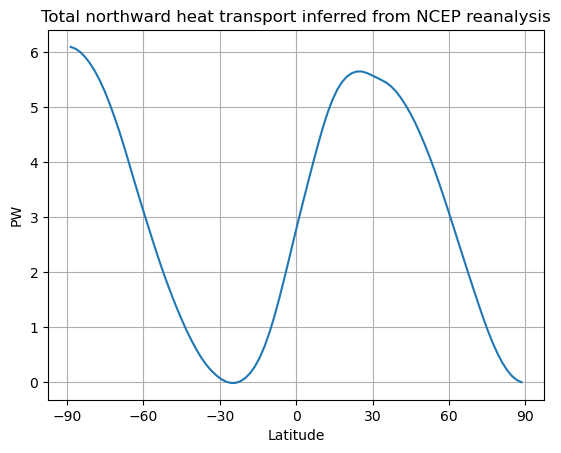

In [9]:
#  Need to flip the arrays because we want to start from the south pole
Rtoa_ncep = ASRzon-OLRzon
lat_ncep = ASRzon.lat
fig, ax = plt.subplots()
ax.plot(lat_ncep, inferred_heat_transport(Rtoa_ncep))
ax.set_ylabel('PW')
ax.set_xlabel('Latitude')
ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])
ax.grid()
ax.set_title('Total northward heat transport inferred from NCEP reanalysis')


The net downward TOA radiation flux in NCEP renalysis data is -12.0 W/m2.
The net downward TOA radiation flux after balancing the data is -1.66e-06 W/m2.


Text(0.5, 1.0, 'Total northward heat transport inferred from NCEP reanalysis (after global balancing)')

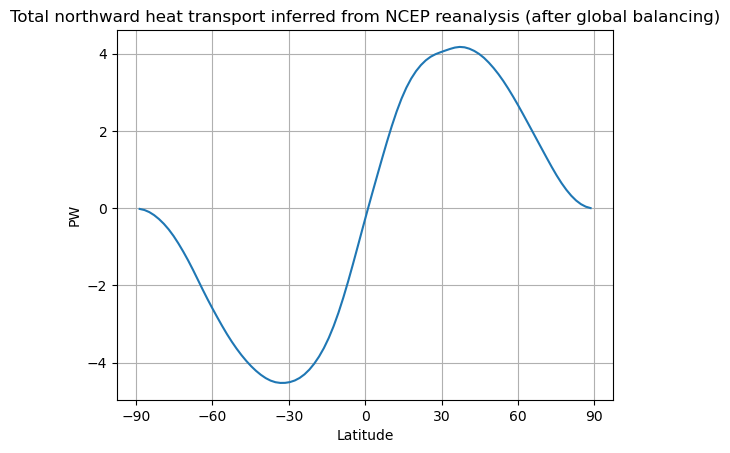

In [10]:
#  global average of TOA radiation in reanalysis data
weight_ncep = np.cos(np.deg2rad(lat_ncep)) / np.cos(np.deg2rad(lat_ncep)).mean(dim='lat')
imbal_ncep = (Rtoa_ncep).weighted(weight_ncep).mean(dim='lat')
print( 'The net downward TOA radiation flux in NCEP renalysis data is %0.1f W/m2.' %imbal_ncep)

Rtoa_ncep_balanced = Rtoa_ncep - imbal_ncep
newimbalance = float(Rtoa_ncep_balanced.weighted(weight_ncep).mean(dim='lat'))
print( 'The net downward TOA radiation flux after balancing the data is %0.2e W/m2.' %newimbalance)

fig, ax = plt.subplots()
ax.plot(lat_ncep, inferred_heat_transport(Rtoa_ncep_balanced))
ax.set_ylabel('PW')
ax.set_xlabel('Latitude')
ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])
ax.grid()
ax.set_title('Total northward heat transport inferred from NCEP reanalysis (after global balancing)')

Text(0.5, 1.0, 'Net upward surface energy flux in NCEP Reanalysis data')

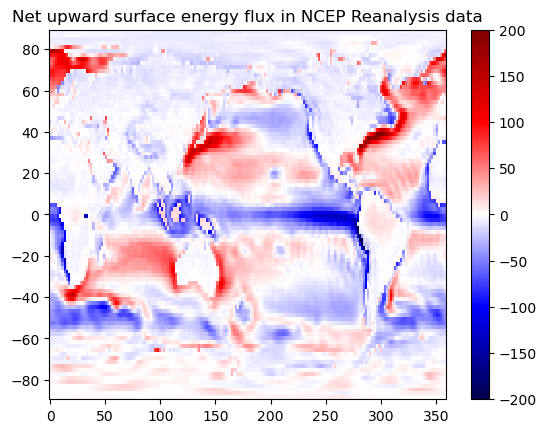

In [11]:
# monthly climatologies for surface flux data from reanalysis
#  all defined as positive UP
ncep_url = "/Users/yuchiaol_ntuas/Desktop/ebooks/data/"
ncep_nswrs = xr.open_dataset(ncep_url + "nswrs.sfc.mon.1981-2010.ltm.nc", decode_times=False)
ncep_nlwrs = xr.open_dataset(ncep_url + "nlwrs.sfc.mon.1981-2010.ltm.nc", decode_times=False)
ncep_shtfl = xr.open_dataset(ncep_url + "shtfl.sfc.mon.1981-2010.ltm.nc", decode_times=False)
ncep_lhtfl = xr.open_dataset(ncep_url + "lhtfl.sfc.mon.1981-2010.ltm.nc", decode_times=False)

#  Calculate ANNUAL AVERAGE net upward surface flux
ncep_net_surface_up = (ncep_nlwrs.nlwrs
                     + ncep_nswrs.nswrs
                     + ncep_shtfl.shtfl
                     + ncep_lhtfl.lhtfl
                      ).mean(dim='time')

lon_ncep = ncep_net_surface_up.lon
fig, ax = plt.subplots()
cax = ax.pcolormesh(lon_ncep, lat_ncep, ncep_net_surface_up, 
               cmap=plt.cm.seismic, vmin=-200., vmax=200. )
fig.colorbar(cax, ax=ax)
ax.set_title('Net upward surface energy flux in NCEP Reanalysis data')


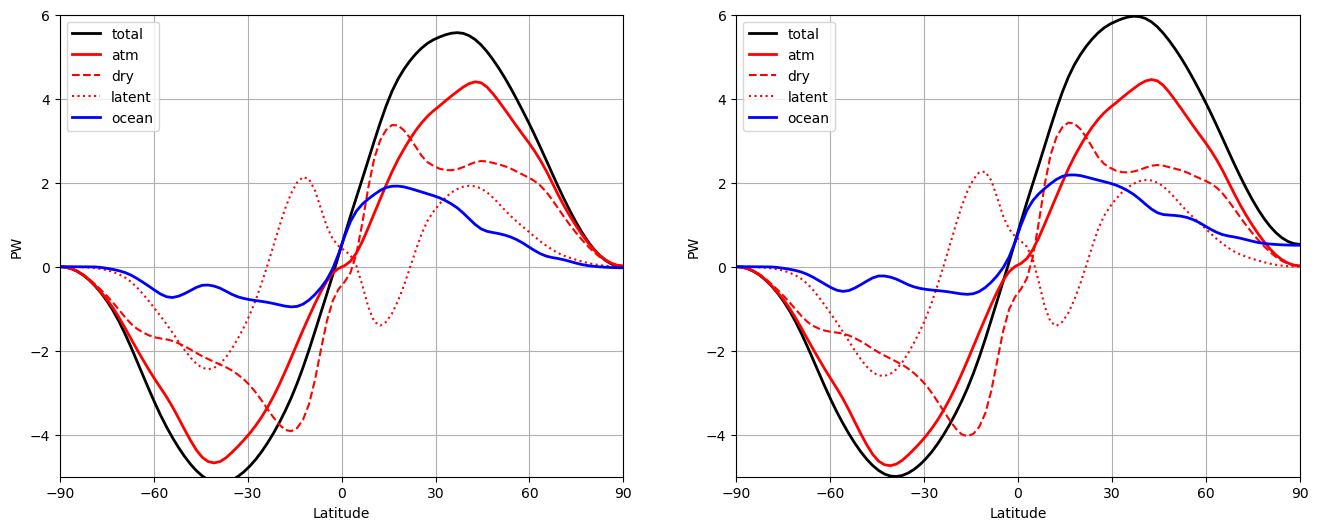

In [12]:
def CESM_heat_transport(run, timeslice=clim_slice_cpl):
    #  Take zonal and time averages of the necessary input fields
    fieldlist = ['FLNT','FSNT','LHFLX','SHFLX','FLNS','FSNS','PRECSC','PRECSL','QFLX','PRECC','PRECL']
    zon = run[fieldlist].isel(time=timeslice).mean(dim=('lon','time'))
    OLR = zon.FLNT
    ASR = zon.FSNT
    Rtoa = ASR - OLR  # net downwelling radiation
    #  surface energy budget terms, all defined as POSITIVE UP
    #    (from ocean to atmosphere)
    LHF = zon.LHFLX
    SHF = zon.SHFLX
    LWsfc = zon.FLNS
    SWsfc = -zon.FSNS
    SnowFlux =  ((zon.PRECSC + zon.PRECSL) *
                      const.rho_w * const.Lhfus)
    # net upward radiation from surface
    SurfaceRadiation = LWsfc + SWsfc
    # net upward surface heat flux
    SurfaceHeatFlux = SurfaceRadiation + LHF + SHF + SnowFlux
    # net heat flux into atmosphere
    Fatmin = Rtoa + SurfaceHeatFlux
    #  hydrological cycle, all terms in  kg/m2/s or mm/s
    Evap = zon.QFLX
    Precip = (zon.PRECC + zon.PRECL) * const.rho_w
    EminusP = Evap - Precip
        
    # heat transport terms
    HT = {}
    HT['total'] = inferred_heat_transport(Rtoa)
    HT['atm'] = inferred_heat_transport(Fatmin)
    HT['ocean'] = inferred_heat_transport(-SurfaceHeatFlux)
    HT['latent'] = inferred_heat_transport(EminusP*const.Lhvap) # atm. latent heat transport from moisture imbal.
    HT['dse'] = HT['atm'] - HT['latent']  # dry static energy transport as residual

    return HT

#  Compute heat transport partition for both control and 2xCO2 simulations
HT_control = CESM_heat_transport(atm['cpl_control'])
HT_2xCO2 = CESM_heat_transport(atm['cpl_CO2ramp'])

fig = plt.figure(figsize=(16,6))
runs = [HT_control, HT_2xCO2]
N = len(runs)

for n, HT in enumerate([HT_control, HT_2xCO2]):
    ax = fig.add_subplot(1, N, n+1)
    ax.plot(lat_cesm, HT['total'], 'k-', label='total', linewidth=2)
    ax.plot(lat_cesm, HT['atm'], 'r-', label='atm', linewidth=2)
    ax.plot(lat_cesm, HT['dse'], 'r--', label='dry')
    ax.plot(lat_cesm, HT['latent'], 'r:', label='latent')
    ax.plot(lat_cesm, HT['ocean'], 'b-', label='ocean', linewidth=2)

    ax.set_xlim(-90,90)
    ax.set_ylim(-5,6)
    ax.set_xticks(ticks)
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlabel('Latitude')
    ax.set_ylabel('PW')

